<a href="https://colab.research.google.com/github/vijaygwu/SEAS8525/blob/main/Class_2_CL_Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


The SimCLR approach aims to learn meaningful representations of images in a self-supervised manner. It does this by maximizing the cosine similarity between representations of augmented views of the same image (positive pairs) and minimizing the cosine similarity between representations of different images (negative pairs). The contrastive loss encourages the encoder to learn representations that are invariant to the applied data augmentations.

The visualization using t-SNE allows us to assess the quality of the learned representations by observing how well the different classes are separated in the low-dimensional space.

This code demonstrates the implementation of a self-supervised learning approach called SimCLR (Simple Framework for Contrastive Learning of Visual Representations) using the CIFAR-10 dataset. Let's go through the code section by section:

1. Importing Libraries:
   - The necessary libraries, including TensorFlow, Keras, Matplotlib, and scikit-learn, are imported.

2. Loading and Preprocessing Data:
   - The CIFAR-10 dataset is loaded using `keras.datasets.cifar10.load_data()`.
   - The pixel values of the training and testing data are normalized to the range [0, 1].
   - The training data is converted into a TensorFlow Dataset using `tf.data.Dataset.from_tensor_slices()` and batched.

3. Data Augmentation:
   - A data augmentation pipeline is defined using `keras.Sequential()` to apply random cropping, flipping, rescaling, and zooming to the input images.

4. Defining the Encoder Network:
   - The `create_encoder` function defines the base encoder network using convolutional layers, max pooling, and a global max pooling layer.
   - The encoder network takes an input image and outputs a 128-dimensional feature representation.

5. Defining the Projection Head:
   - The `create_projection_head` function defines the projection head network using dense layers.
   - The projection head takes the 128-dimensional feature representation from the encoder and projects it to a 128-dimensional space.

6. Training Loop:
   - The training loop runs for a specified number of epochs.
   - For each batch of training data:
     - The encoder and projection head are applied to the batch of images.
     - The resulting projected representations are L2-normalized.
     - The cosine similarity matrix is computed between the normalized representations.
     - The contrastive loss is calculated using the cosine similarity matrix and temperature scaling.
     - The gradients of the loss with respect to the weights of the encoder and projection head are computed.
     - The optimizer is used to update the weights of the encoder and projection head.

7. Extracting Representations:
   - After training, the trained encoder is used to extract representations (embeddings) for the test images.

8. t-SNE Visualization:
   - The t-SNE algorithm is used to reduce the dimensionality of the learned representations to 2D.
   - The t-SNE results are plotted using Matplotlib, with each point colored according to its true class label.



Start of epoch 0
Training loss (for one batch) at step 0: 5.04012393951416
Training loss (for one batch) at step 100: 5.545156955718994

Start of epoch 1
Training loss (for one batch) at step 0: 4.203945159912109
Training loss (for one batch) at step 100: 2.619403600692749

Start of epoch 2
Training loss (for one batch) at step 0: 1.0901789665222168
Training loss (for one batch) at step 100: 0.4749756455421448

Start of epoch 3
Training loss (for one batch) at step 0: 0.26092472672462463
Training loss (for one batch) at step 100: 0.16961582005023956

Start of epoch 4
Training loss (for one batch) at step 0: 0.14041109383106232
Training loss (for one batch) at step 100: 0.09762687236070633

Start of epoch 5
Training loss (for one batch) at step 0: 0.0870266705751419
Training loss (for one batch) at step 100: 0.06983794271945953

Start of epoch 6
Training loss (for one batch) at step 0: 0.06834259629249573
Training loss (for one batch) at step 100: 0.05997801572084427

Start of epoch 7


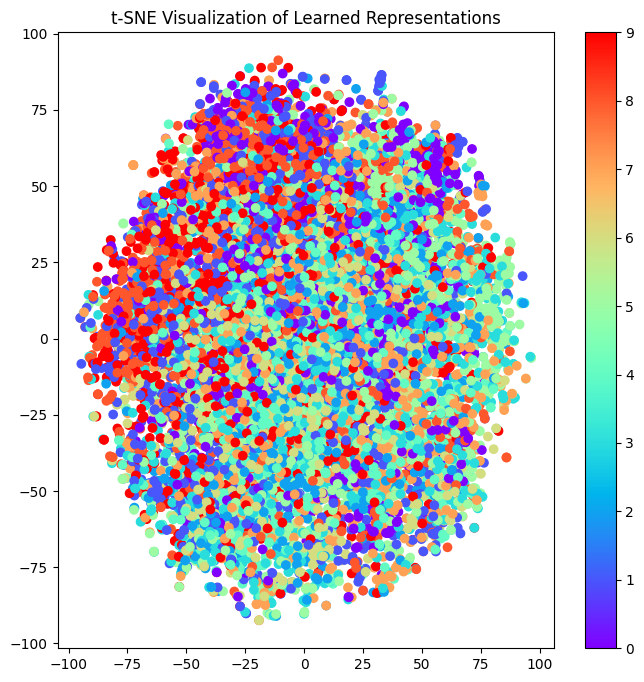

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load and preprocess the CIFAR-10 dataset
(x_train, _), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0

# Convert the training data into a TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

# Define the data augmentation function
data_augmentation = keras.Sequential([
    layers.RandomCrop(height=32, width=32),
    layers.RandomFlip("horizontal"),
    layers.Rescaling(1./255),
    layers.RandomZoom(0.2),
])

# Define the base encoder network
def create_encoder():
    inputs = layers.Input(shape=(32, 32, 3))
    x = data_augmentation(inputs)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.GlobalMaxPooling2D()(x)
    outputs = layers.Dense(128)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

# Define the projection head
def create_projection_head():
    inputs = keras.Input(shape=(128,))
    x = layers.Dense(256, activation='relu')(inputs)
    outputs = layers.Dense(128)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

encoder = create_encoder()
projection_head = create_projection_head()

optimizer = keras.optimizers.Adam()
batch_size = 256
epochs = 1000
temperature = 0.1

# Custom training loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch}")
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # Forward pass
            encoded = encoder(x_batch_train, training=True)
            projected = projection_head(encoded, training=True)
            normalized = tf.math.l2_normalize(projected, axis=1)
            cosine_similarity = tf.matmul(normalized, normalized, transpose_b=True)
            logits = cosine_similarity / temperature
            labels = tf.range(x_batch_train.shape[0])
            loss_value = keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
            loss_value = tf.reduce_mean(loss_value)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, encoder.trainable_weights + projection_head.trainable_weights)

        # Update the weights of the encoder and projection head.
        optimizer.apply_gradients(zip(gradients, encoder.trainable_weights + projection_head.trainable_weights))

        if step % 100 == 0:
            print(f"Training loss (for one batch) at step {step}: {float(loss_value)}")

# Extract representations after training
representations = encoder.predict(x_test)

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000)
tsne_results = tsne.fit_transform(representations)

plt.figure(figsize=(8, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test.flatten(), cmap='rainbow')
plt.title('t-SNE Visualization of Learned Representations')
plt.colorbar()
plt.show()
